In [4]:
import os
from tqdm import tqdm, tqdm_notebook
import numpy as np
import pandas as pd
from scipy.misc import imread
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
tf.python.control_flow_ops = control_flow_ops

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dropout
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split

In [2]:
data_path = './driving-data/'
img_rows, img_cols = 160, 320

In [5]:
def load_data():
    columns = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']

    print('Loading driving log ...')

    driving_log = pd.read_csv(data_path+'driving_log.csv', names=columns)
    num_rows = len(driving_log.index)

    train_images = np.zeros((num_rows, img_rows, img_cols, 3))
    train_steering = driving_log.as_matrix(['steering'])

    for index, row in tqdm_notebook(driving_log.iterrows(), unit=' rows', total=num_rows):
        fname = os.path.basename(row['center'])
        # Normalized YUV
        train_images[index] = imread(data_path+'IMG/'+fname, False, 'YCbCr')/255.

    print('Loaded', num_rows, 'rows.')
    return train_images, train_steering

In [6]:
X_train, y_train = load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=0)

Loading driving log ...

Loaded 3685 rows.


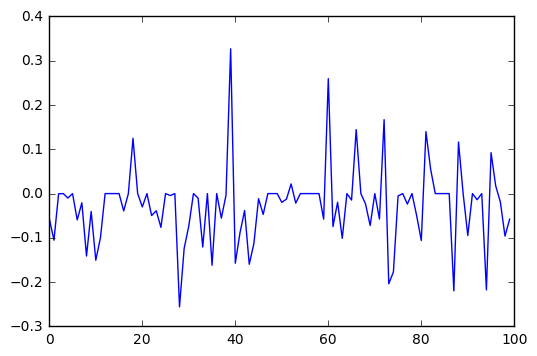

In [8]:
plt.plot(y_train[:100])
plt.show()

In [15]:
model = Sequential()
model.add(Convolution2D(32, 5, 5,border_mode='valid',
                        input_shape=(img_rows, img_cols, 3)))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.add(MaxPooling2D((4,4)))

model.add(Convolution2D(64, 3, 3, subsample=(2,2)))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.add(Dense(1))

In [16]:
model.compile('adam', 'mse', metrics=['accuracy'])

Compiling model ...


In [ ]:
h = model.fit(X_train, y_train, batch_size=32, nb_epoch=10,
    validation_data=(X_val, y_val), verbose=1, shuffle=True)

Train on 2948 samples, validate on 737 samples
Epoch 1/10
2948/2948 [==============================] - 13s - loss: 0.0333 - acc: 0.2802 - val_loss: 0.0126 - val_acc: 0.2836
Epoch 2/10
2948/2948 [==============================] - 13s - loss: 0.0149 - acc: 0.2832 - val_loss: 0.0105 - val_acc: 0.2836
Epoch 3/10
2948/2948 [==============================] - 13s - loss: 0.0151 - acc: 0.2832 - val_loss: 0.0102 - val_acc: 0.2836
Epoch 4/10
2948/2948 [==============================] - 13s - loss: 0.0101 - acc: 0.2832 - val_loss: 0.0108 - val_acc: 0.2836
Epoch 5/10
2944/2948 [============================>.] - ETA: 0s - loss: 0.0091 - acc: 0.2833

In [14]:
y_pred = model.predict(X_val, batch_size=16)
np.hstack((y_pred, y_val))

array([[ 0.00779052, -0.00427218],
       [ 0.04612364,  0.05894623],
       [ 0.00140466,  0.        ],
       ..., 
       [-0.07747142, -0.01977101],
       [ 0.16216035,  0.06346763],
       [ 0.0027311 ,  0.05306841]])

In [ ]:
model_json = model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights('my_model.h5')